# Basics of Machine learning Algorithms
##Decision Tree for Regression problems

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
from graphviz import Digraph

from numpy.typing import NDArray
from typing import Set, Optional, List, Literal, Tuple
from dataclasses import dataclass
from sklearn.metrics import r2_score
from collections import Counter

# Implement Algorithm with toy dataset
In order to test our implementation lets work with a toy dataset and visualize it. The values are taken from a [blog post](https://medium.com/analytics-vidhya/regression-trees-decision-tree-for-regression-machine-learning-e4d7525d8047).




shape of Xtrain is (14, 1) and y_train is (14,)


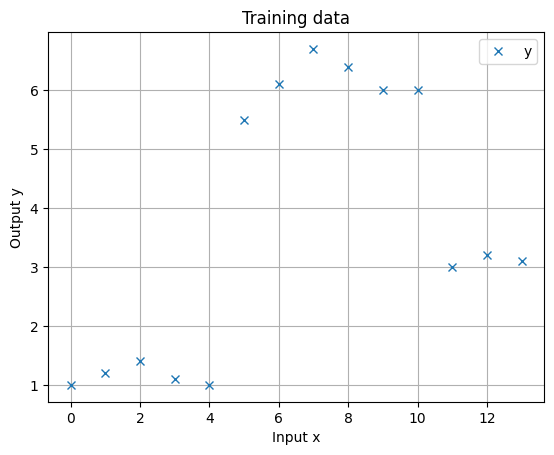

In [ ]:
# Load inputs and labels
X_train = np.arange(14).reshape(-1, 1)
y_train = np.array([1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1])
#y_train = np.array([1, 1, 1, 1, 1, 5, 6, 6, 6, 6, 6, 3, 3, 3])
# plot training data
fig, ax = plt.subplots()
ax.plot(X_train, y_train, "x", label="y")
ax.set_xlabel("Input x")
ax.set_ylabel("Output y")
ax.grid()
ax.legend()
ax.set_title("Training data");
print(f'shape of Xtrain is {X_train.shape} and y_train is {y_train.shape}')

### Decision Tree Regressor
Implemented a decision tree class `DecisionTreeRegressor`,  to train the decision tree and `predict(X)` to evaluate the *fitted* decision tree. The class can get additional methods based on our preference.

### Error metric
As metric use the mean-squared error $\operatorname{MSE}:Y \times Y \rightarrow \mathbb{R}$ where the prediction is the mean over all labels in the subset, $\hat{y} = 1/n \sum_{i=1}^n y_i$, where $n$ is the number of samples in the subset and $y_i$ the true label.

For the total error use a weighted average and use the number of samples as weighting factor:
$$\overline{MSE} = \frac{n_1 \operatorname{MSE}((y)_1,(\hat{y})_1) + n_2 \operatorname{MSE}((y)_2,(\hat{y})_2)}{n_1+n_2}$$

In [ ]:
@dataclass
class Split:
    feature: int
    threshold: np.float64
    left: Set[NDArray[np.float64]] # X and y of left subtree
    right: Set[NDArray[np.float64]] # X and y of right subtree


@dataclass
class TreeNode:
    value: np.float64
    feature: Optional[np.float64]
    threshold: Optional[np.float64]
    left: Optional["TreeNode"]
    right: Optional["TreeNode"]

In [ ]:
class Node:
    def __init__(self , feature=None, threshold=None , left = None, right=None , *, value = None): # * is so that value is only passed to leaf nodes
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
class DecisionTreeRegressor:
    def __init__(self, max_depth: int = 5, min_split: int = 2 , problem : str = 'classification') -> None:
        """Descision tree for regression

        max_depth - maximum depth of a decision tree (default 5)
        min_split - minimum number of samples in a subtree (default 2)
        """
        self.max_depth = max_depth
        self.min_split = min_split
        self.problem = problem
        self.tree = None
        self.root = None

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Training method of decision tree

        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        y - labels of the training data.
        """
        #
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X,y)

        assert len(X.shape) > 1
        pass

    def _grow_tree(self, X, y , depth=0):
        n_samples , n_feats  = X.shape
        n_labels = np.unique(y)

        # stopping creiteria for the tree to stop spliting ...
        if (depth >= self.max_depth  or n_samples <= self.min_split ):
            if self.problem == 'classification' or len(n_labels) == 1:
                leaf_value = self._most_common_label(y)
            elif self.problem == 'regression':
                leaf_value = np.mean(y)
            return Node(value= leaf_value)

        feat_idxs = np.random.choice(X.shape[1],X.shape[1],replace=False) # shuffle the features columns. - feature indices

        # find the best split
        best_feature , best_thresh = self._best_split(X, y , feat_idxs) # to get the best attribute and its threshold point for spliting

        if best_thresh is None:
            leaf_value = np.mean(y)
            return Node(value = leaf_value)

        # find the child node
        left_idxs , right_idxs = self._split(X[:,best_feature],best_thresh) # return list of samples containing the indices of the left and right child nodes.
        left = self._grow_tree(X[left_idxs,:],y[left_idxs],depth+1) # an object of the class Node which points to the left child node of current node.
        right = self._grow_tree(X[right_idxs,:],y[right_idxs], depth+1)
        return Node(best_feature, best_thresh,left,right)  # best feature, best threshold , left and right nodes are updated to the current node.

    def to_graphviz(self):
        dot_str = "digraph Tree {\n"
        dot_str += self._add_nodes_edges(self.root)[0]
        dot_str += "}"
        return dot_str

    def _add_nodes_edges(self, node, counter=0):
        dot_str = ""
        node_id = counter
        counter += 1

        if node.is_leaf_node():
            dot_str += f'  node{node_id} [label="Leaf: {node.value}", shape="box"];\n'
        else:
            dot_str += f'  node{node_id} [label="X{node.feature} <= {node.threshold:.2f}"];\n'
            if node.left:
                left_id = counter
                dot_str += f'  node{node_id} -> node{left_id};\n'
                left_str, counter = self._add_nodes_edges(node.left, counter)
                dot_str += left_str
            if node.right:
                right_id = counter
                dot_str += f'  node{node_id} -> node{right_id};\n'
                right_str, counter = self._add_nodes_edges(node.right, counter)
                dot_str += right_str

        return dot_str, counter

    def _best_split(self, X, y, feat_idxs):
        #initialize the gain and split indices and thresholds
        best_gain = -1
        split_idx , split_threshold = None, None

        for feat_idx in feat_idxs: # go through each attributes
            X_column = X[:,feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain for each threshold in an attribute
                if self.problem == 'classification':
                    gain = self._information_gain(y,X_column, thr)
                else:
                    gain = self._ig_mse(y,X_column, thr)

                if gain > best_gain: # update the highest information gain and its corresponding attributes and thresold
                    best_gain = gain
                    split_idx = feat_idx # attribute index of the best gain
                    split_threshold = thr # threshold to split the best attribute
        return split_idx ,split_threshold

    def _ig_mse(self,y,X_column, threshold):   #information gain for regression problem based on Mean Square Error
        # Varience of parent node
        parent_node_mse = np.var(y)
        # split the data based theshold
        left_idxs , right_idxs = self._split(X_column,threshold)
        # Calculate the variance of the target variable in the left and right child nodes
        lt_var , rt_var = np.var(y[left_idxs]), np.var(y[right_idxs])
        # calculate the weighted sum of varience of each child node
        n= len(y)
        n_l ,n_r = len(left_idxs) , len(right_idxs)

        if n_l == 0 or n_r == 0:
            return 0

        child_var = (n_l/n)*lt_var +(n_r/n)*rt_var
        #information gain
        gain = parent_node_mse - child_var
        return gain

    def _information_gain(self, y, X_column, threshold): #Entropy(parent) - [weighted average]*Entropy(children)

        # parent entropy
        parent_entropy = self._entropy(y)
        # child entropy --> entropy for each threshold
        '''need to find out the no: of samples of left and right of the threshold : hint each time we are spliting in to 2'''
        left_idxs , right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs)==0 :
            return 0

        # calculate the weighted avg of entropy of childnodes. = sum of (probability of getting that node * entropy of that node)
        n = len(y)
        n_l , n_r = len(left_idxs) , len(right_idxs)
        e_l , e_r = self._entropy(y[left_idxs]) , self._entropy(y[right_idxs])
        child_entropy = (n_l/n)*e_l +(n_r/n)*e_r

        # information gain of each threshold
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten() # returns 1D array of the indices of samples in the left side of threshold
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y): # -sum of ( P * log P) , P is the frequency of occuring that element in the total samples = probablity
        hist = np.bincount(y) # create a list like histogram specify the no: of occurance of each unique elements in the sample
        ps = hist/ len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value


    def predict(self, X: NDArray[np.float64]):
        """Prediction method of trained decision tree

        INPUT
        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        OUTPUT
        y_hat - predicted labels, size = (N)
        """
        return np.array([self._traverse_tree(x , self.root) for x in X])
        # N, n = X.shape
        # return np.zeros(N)
    def _traverse_tree(self, x , node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold :
            return self._traverse_tree(x , node.left)
        return self._traverse_tree(x , node.right)

Now fit the decision tree to the training data

In [ ]:
tree_reg = DecisionTreeRegressor(problem='regression')
tree_reg.fit(X_train, y_train)

C:\Users\jasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\jasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Evaluate the results on a discrete grid `X_eval`.

In [ ]:
# Generate a grid of values over the feature space for plotting the true model
X_eval = np.linspace(0, 15, 50).reshape(-1, 1)
y_hat_eval = tree_reg.predict(X_eval)
y_hat_eval

array([1.  , 1.3 , 1.3 , 1.3 , 1.3 , 1.3 , 1.3 , 1.05, 1.05, 1.05, 1.05,
       1.05, 1.05, 1.05, 5.5 , 5.5 , 5.5 , 6.1 , 6.1 , 6.1 , 6.55, 6.55,
       6.55, 6.55, 6.55, 6.55, 6.55, 6.  , 6.  , 6.  , 6.  , 6.  , 6.  ,
       3.  , 3.  , 3.  , 3.15, 3.15, 3.15, 3.15, 3.15, 3.15, 3.15, 3.15,
       3.15, 3.15, 3.15, 3.15, 3.15, 3.15])

Plot the results

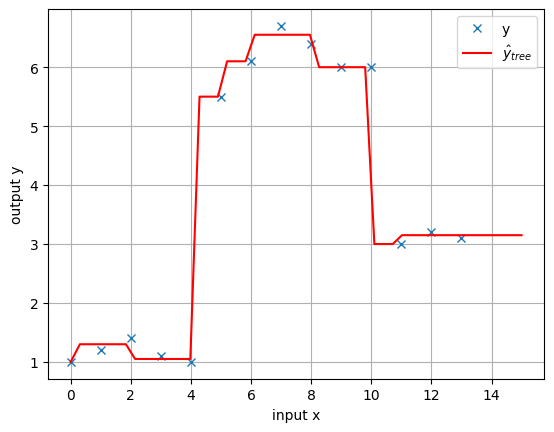

In [ ]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, "x", label="y")
ax.plot(X_eval, y_hat_eval, label=r"$\hat{y}_{tree}$", color='red')
#ax.scatter(X_eval, y_hat_eval)
ax.set_xlabel("input x")
ax.set_ylabel("output y")
ax.grid()
ax.legend();

## Linear Regression model
For comparison, lets use linear regression model with quadratic features and train it on `X_train`, `y_train`. We then compare the predictions on the evaluation dataset `X_eval`.

In [ ]:
class LinearRegressor:
    def __init__(self, feature_type: Literal["lin", "quad", "rbf"] = "quad") -> None:
        """Linear regression model

        feature_type - Data embedding
        """
        self.feature_type = feature_type
        self.beta_hat = None

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Training method of linear regresseion

        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        y - labels of the training data.
        """
        self.beta_hat = (
            np.linalg.inv(phi(X, self.feature_type).T @ phi(X, self.feature_type))
            @ phi(X, self.feature_type).T
            @ y
        )

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Prediction method of linear regression model

        INPUT
        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        OUTPUT
        y_hat - predicted labels, size = (N)
        """
        return phi(X, self.feature_type) @ self.beta_hat


def phi(
    x: NDArray[np.float64], feat_type: Literal["lin", "quad", "rbf"] = "quad"
) -> NDArray[np.float64]:
    N, nx = x.shape
    if feat_type == "lin":
        return np.hstack((np.ones((N, 1)), x))
    elif feat_type == "quad":
        if nx == 1:
            return np.hstack(
                (
                    np.ones((N, 1)),
                    x,
                    x**2,
                )
            )
        elif nx == 2:
            return np.hstack(
                (
                    np.ones((N, 1)),
                    x,
                    (x[:, 0] ** 2).reshape((N, 1)),
                    (x[:, 0] * x[:, 1]).reshape((N, 1)),
                    (x[:, 1] ** 2).reshape((N, 1)),
                )
            )
        else:
            raise NotImplementedError
    elif feat_type == "rbf":
        b = lambda x, c: np.exp(-1 / 2 * (x - c) ** 2)
        rbf_list = []
        rbf_list.append(np.ones((N, 1)))
        for j in range(0, 15, 1):
            rbf_list.append(b(x, j))
        return np.hstack(rbf_list)
    else:
        raise NotImplementedError

In [ ]:
lin_reg = LinearRegressor("quad")
lin_reg.fit(X_train, y_train)
y_hat_lin_eval = lin_reg.predict(X_eval)

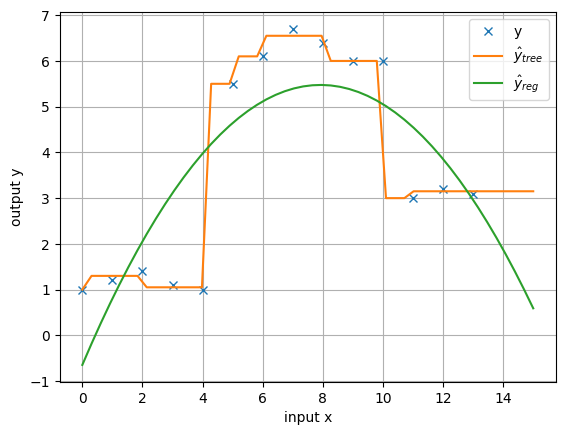

In [ ]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, "x", label="y")
ax.plot(X_eval, y_hat_eval, label=r"$\hat{y}_{tree}$")
ax.plot(X_eval, y_hat_lin_eval, label=r"$\hat{y}_{reg}$")
ax.set_xlabel("input x")
ax.set_ylabel("output y")
ax.grid()
ax.legend();

## More features
In this part we will show a comparison between linear regression and a decision tree regressor for a dataset that has two features.

In [ ]:
# Generate a synthetic dataset based on a parabola
n_samples = 100
X_train = np.random.rand(n_samples, 2) * 2 - 1  # Two features in range [-1, 1]
y = X_train[:, 0] ** 2 + X_train[:, 1] ** 2  # True model without noise

# Add noise to create the observed target variable
y_train = y + np.random.randn(n_samples) * 0.1

# Train a decision tree regressor
tree = DecisionTreeRegressor(problem='regression')
tree.fit(X_train, y_train)

# Train a linear regression model with quadratic features
lin_reg = LinearRegressor("quad")
lin_reg.fit(X_train, y_train)

# Generate a grid of values over the feature space for plotting the true model
x1_grid, x2_grid = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
x1, x2 = np.meshgrid(x1_grid, x2_grid)
X_test = np.c_[x1.ravel(), x2.ravel()]
y_test = x1**2 + x2**2

# Predict the target values for the grid using the trained regressors
y_hat_tree = tree.predict(X_test).reshape(x1.shape)
y_hat_lin_reg = lin_reg.predict(X_test).reshape(x1.shape)

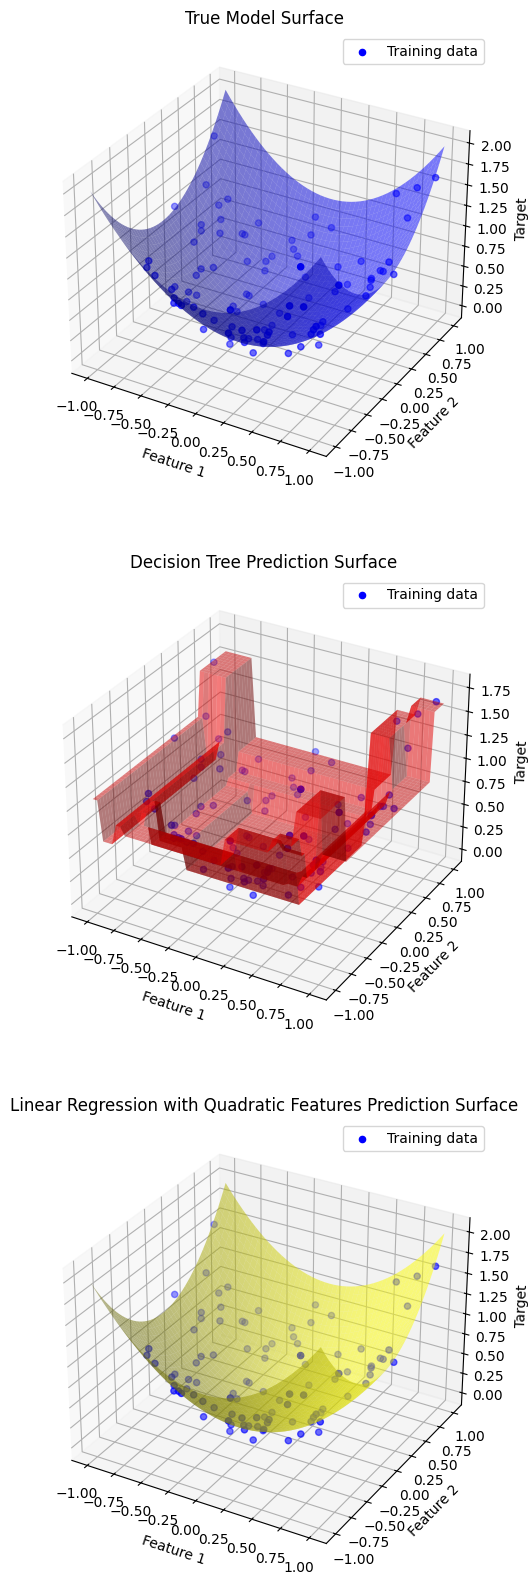

In [ ]:
fig = plt.figure(figsize=(10, 20))

# Plot the true model surface
ax = fig.add_subplot(311, projection="3d")
ax.plot_surface(x1, x2, y_test, color="blue", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color="blue", label="Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.set_title("True Model Surface")
ax.legend()

# Plot the decision tree prediction surface
ax = fig.add_subplot(312, projection="3d")
ax.plot_surface(x1, x2, y_hat_tree, color="red", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color="blue", label="Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.set_title("Decision Tree Prediction Surface")
ax.legend()

# Plot the linear regression with quadratic features prediction surface
ax = fig.add_subplot(313, projection="3d")
ax.plot_surface(x1, x2, y_hat_lin_reg, color="yellow", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color="blue", label="Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.set_title("Linear Regression with Quadratic Features Prediction Surface")
ax.legend();

# Predict the price of American houses - Kaggle dataset
we use the *American housing dataset* from [kaggle](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset).

In [ ]:
# american housing
label_name = ["price"]
feature_names = ["area", "bedrooms", "bathrooms", "stories", "parking"]
filepath = "Housing.csv"


def load_data(
    filepath: str, label_name: List[str], feature_names: List[str]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Load dataset from csv file

    Input:
    filepath - full file path to csv file
    label_name - column name of label
    feature_names - column name of features

    Output:
    y - labels shape(N,1)
    X - samples shape(N,n), where N is the number of samples and n is the number of features
    """
    data_df = pd.read_csv(filepath)

    return (data_df[label_name].to_numpy(), data_df[feature_names].to_numpy())


y, X = load_data(filepath, label_name, feature_names)
print(f"{y.shape}, {X.shape}")

(545, 1), (545, 5)


Load the CSV model  and preprocess the data before training

In [ ]:
filepath= "Housing.csv"
label_name = ['price']
feature_names = ["area", "bedrooms", "bathrooms", "stories", "parking"]
#feature_names = ["area"]
data = pd.read_csv(filepath)
# extract the features and labels from it
X = data[feature_names]
y = data[label_name]
data.head()
X = X.to_numpy()
y = y.to_numpy().flatten()
print(f"{y.shape}, {X.shape}")
y

In [ ]:
def train_test_split(
    X: NDArray[np.float64], y: NDArray[np.float64], test_split: np.float64 = 0.3
) -> Tuple[
    NDArray[np.float64], NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]
]:
    N, n = X.shape

    indices = np.random.permutation(N) # shuffle the N indices returns an array 1D

    test_size = int(N * test_split)
    test_indices = indices[:test_size] # the first % of shuffles indices --> testsize and remaining in to train
    train_indices = indices[test_size:]
    X_train , X_test = X[train_indices] , X[test_indices]
    y_train , y_test = y[train_indices] , y[test_indices]


    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)
print(f"the shapes {y_train.shape}, {X_train.shape}, {y_test.shape}, {X_test.shape}")

the shapes (436,), (436, 5), (109,), (109, 5)


## Error and hyperparameter optimization



In [ ]:
# Normalised MSE --> MSE can be normalised using Range or Standard deviation of the observed data
''' 0 : Perfect prediction with no error.
    < 1: Indicates good predictive performance, with smaller values indicating better accuracy.
    > 1: Indicates poorer predictive performance relative to the variability in the data.'''
def nrmse(y_test, y_preds):
    mse = np.mean((y_test - y_preds)**2)
    rmse = np.sqrt(mse)
    std = np.std(y_test)
    return rmse/std

nrmse_s = []
depths = range(2,8)
for i in depths:  #
    tree= DecisionTreeRegressor(max_depth=i,problem='regression')
    tree.fit(X_train, y_train)
    y_preds = tree.predict(X_test)
    nrmse_s.append(nrmse(y_test,y_preds))
print(nrmse_s)

nrmse_s_training =[]
depths = range(2,8)
for i in depths:
    tree= DecisionTreeRegressor(max_depth=i,problem='regression')
    tree.fit(X_train, y_train)
    y_preds = tree.predict(X_train)
    nrmse_s_training.append(nrmse(y_train,y_preds))
print(nrmse_s_training)

[0.7841047538837931, 0.7607637241516164, 0.71295930677559, 0.7056070218112348, 0.7252779713851235, 0.772810467685216]
[0.7441237432777482, 0.6875540715652492, 0.6461943657726744, 0.5879089752563744, 0.5354499780734815, 0.48247279163617524]


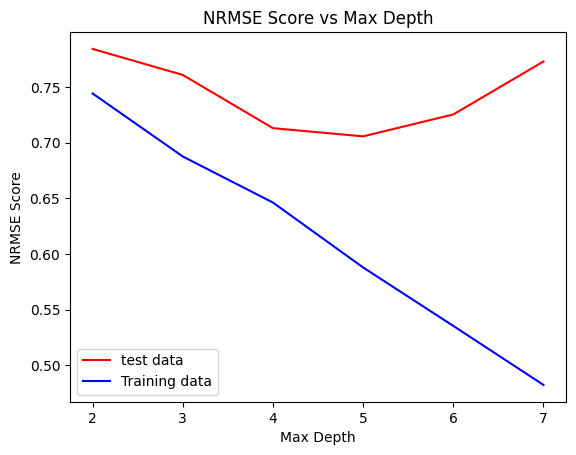

In [ ]:
#print(r2_score)
# Plot the R^2 scores against max_depth
plt.plot(depths, nrmse_s ,color="red", label="test data" )
plt.plot(depths, nrmse_s_training, color="blue", label="Training data")
plt.xlabel('Max Depth')
plt.ylabel('NRMSE Score')
plt.title('NRMSE Score vs Max Depth')
plt.legend()
plt.show()